#### Cloning Git Repository & Importing Dependencies

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2650, done.
remote: Counting objects: 100% (2650/2650), done.
remote: Compressing objects: 100% (2311/2311), done.
^C


In [ ]:
!pip install -Uqr models/official/requirements.txt

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.5/230.5 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 38.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Data \Hack

Mounted at /content/drive
/content/drive/MyDrive/Data Hack


#### Two Different preprocesssing functions

In [ ]:
from unicodedata import normalize
import re
def analyser(x):
    x = str(x)
    x = re.sub(r'http\S+', '', x)    #Remove Url links
    x = normalize('NFC', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')  #Fix non alphabetic caracters
    x = x.lower()  #Lower case
    x = re.sub("[^a-z ,.!?]", " ", x)   #Remove Punctuation (keep "," "." "?" "!")
    x = x.split()
    return " ".join(x).strip()

analyser('hysÂ·terÂ·iÂ·a [ hi stÃ©eree É™ ] - a state of extreme emotion.')   #Example

'hysteria hi steree a state of extreme emotion.'

##### Import Data

In [ ]:
import pandas as pd
import os
df = pd.read_csv("training_data.csv")[["reviews","Label"]]

In [ ]:
import pandas as pd
import os
df = pd.read_csv("training_data.csv")

In [ ]:
df = df.iloc[:,[0,5,6,7,8,10]]

In [ ]:
test = pd.read_csv("testing_data.csv").iloc[:,[0,5,6,7,8]]

In [ ]:
df['Label'] = df['Label'].astype('category')

label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])

##### Check for the distribution

##### apply the preprocessing function

In [ ]:
df

,reviews,Label
0,just got back from shaw s. great oysters. they...,1
1,back from friday saturday nite stays in king d...,1
3,a friend told me about this place but i have t...,0
4,i went to uncommon ground for brunch on a sund...,0
5,"first meal in chicago loved it. had pig ears, ...",0
...,...,...
47171,"ok, nice hotel, but the brunches are a bit wee...",0
47172,costa rican food at it s finest! it s just lik...,1
47173,ive only been here once but from that experien...,0
47174,"nice find in chi town, came with a host of fri...",0


In [ ]:
test = pd.read_csv("testing_data.csv")[["reviews"]]

In [ ]:
test["Label"] = np.zeros(len(test))

In [ ]:
test.reviews = test.reviews.apply(lambda x : analyser(x))

In [ ]:
df.reviews = df.reviews.apply(lambda x : analyser(x))


In [ ]:
df.Label = df.Label.apply(lambda x : 0 if x=="N" else 1 )

In [ ]:
df

,reviews,Label
0,just got back from shaw s. great oysters. they...,1
1,back from friday saturday nite stays in king d...,1
3,a friend told me about this place but i have t...,0
4,i went to uncommon ground for brunch on a sund...,0
5,"first meal in chicago loved it. had pig ears, ...",0
...,...,...
47171,"ok, nice hotel, but the brunches are a bit wee...",0
47172,costa rican food at it s finest! it s just lik...,1
47173,ive only been here once but from that experien...,0
47174,"nice find in chi town, came with a host of fri...",0


In [ ]:
df['review_length'] = df['reviews'].apply(lambda x: len(x.split()))

# Find the maximum length of reviews
max_length = df['review_length'].max()
print("Maximum review length:", max_length)

# Find how many reviews have the maximum length
reviews_with_max_length = df[df['review_length'] == max_length]
num_reviews_with_max_length = len(reviews_with_max_length)
print("Number of reviews with maximum length:", num_reviews_with_max_length)

Maximum review length: 984
Number of reviews with maximum length: 1


In [ ]:
# Calculate the length of each review
df['review_length'] = df['reviews'].apply(lambda x: len(x.split()))

# Count the number of reviews with more than 300 tokens
num_reviews_more_than_300 = len(df[df['review_length'] > 300])

print("Number of reviews with more than 300 tokens:", num_reviews_more_than_300)

Number of reviews with more than 300 tokens: 4182


In [ ]:
df['review_length'] = df['reviews'].apply(lambda x: len(x.split()))

# Find the row with a review that has 1000 tokens
row_to_delete = df[df['review_length'] > 300]

if not row_to_delete.empty:
    # Drop the row from the DataFrame
    df.drop(row_to_delete.index, inplace=True)
    print("Row with review of 1000 tokens deleted.")
else:
    print("No row found with review of 1000 tokens.")

# Remove the review_length column as it's no longer needed
df.drop(columns=['review_length'], inplace=True)

Row with review of 1000 tokens deleted.


In [ ]:
import numpy as np


train_df, test_df = train_test_split(df, random_state=42, train_size=0.99, stratify=df.Label.values)
valid_df, test_df = train_test_split(test_df, random_state=42, train_size=0.5, stratify=test_df.Label.values)

train_df.shape,valid_df.shape,test_df.shape

((46704, 2), (236, 2), (236, 2))

#### Convert to tensorflow dataset

In [ ]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df.reviews.astype(str).values, train_df.Label.astype(int).values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_df.blurb.astype(str).values, valid_df.state.astype(int).values))
  test_data = tf.data.Dataset.from_tensor_slices((test_df.reviews.astype(str).values, test_df.Label.astype(int).values))

  for text, label in train_data.take(1):
    print(text)
    print(label)

In [ ]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df.reviews.astype(str).values, train_df.Label.astype(int).values))
  #valid_data = tf.data.Dataset.from_tensor_slices((valid_df.reviews.astype(str).values, valid_df.Label.astype(int).values))
  test_data = tf.data.Dataset.from_tensor_slices((test.reviews.astype(str).values, test.Label.astype(int).values))

  for text, label in train_data.take(1):
    print(text)
    print(label)

tf.Tensor(b'coast is good. love the spicy miso. quality fish, nice atmosphere. they don t take reservations and delivery is a bit slow. all in all though, its popular for a reason. not much you cannot get elsewhere however.', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


##### Download the Bert model and its tokenizer

In [ ]:
label_list = [0, 1]
max_seq_length = 264
train_batch_size = 16

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",
                            trainable=True)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

##### Create the Mask, Id & Type

In [ ]:
def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid = None,
                                            text_a = text.numpy(),
                                            text_b = None,
                                            label = label.numpy())
  feature = classifier_data_lib.convert_single_example(0, example, label_list,
                                    max_seq_length, tokenizer)

  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

In [ ]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label],
                                Tout=[tf.int32, tf.int32, tf.int32, tf.int32])

  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  x = {
        'input_word_ids': input_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
    }
  return (x, label_id)

In [ ]:
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(to_feature_map,
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)
                          #.cache()
                          .shuffle(1000)
                          .batch(16, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE))

  # valid
  # valid_data = (valid_data.map(to_feature_map,
  #                           num_parallel_calls=tf.data.experimental.AUTOTUNE)
  #                         .batch(16, drop_remainder=True)
  #                         .prefetch(tf.data.experimental.AUTOTUNE))

  test_data = (test_data.map(to_feature_map).batch(1))

##### Check if the code worked well

In [ ]:
train_data.as_numpy_iterator().next()

In [ ]:
test_data.as_numpy_iterator().next()

In [ ]:
train_data.element_spec

({'input_word_ids': TensorSpec(shape=(16, 300), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(16, 300), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(16, 300), dtype=tf.int32, name=None)},
 TensorSpec(shape=(16,), dtype=tf.int32, name=None))

##### Defining the Model

In [ ]:
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                      name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                  name="input_mask")
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                  name="input_type_ids")

  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

  drop = tf.keras.layers.Dropout(0.2)(pooled_output)
  dense = tf.keras.layers.Dense(16, activation="relu")(drop)
  drop2 = tf.keras.layers.Dropout(0.2)(dense)
  output = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(drop2)

  model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': input_type_ids
    },
    outputs=output)
  return model

##### Compiling the Model

In [ ]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 256)]                0         []                            
                                                                                                  
 input_type_ids (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                            

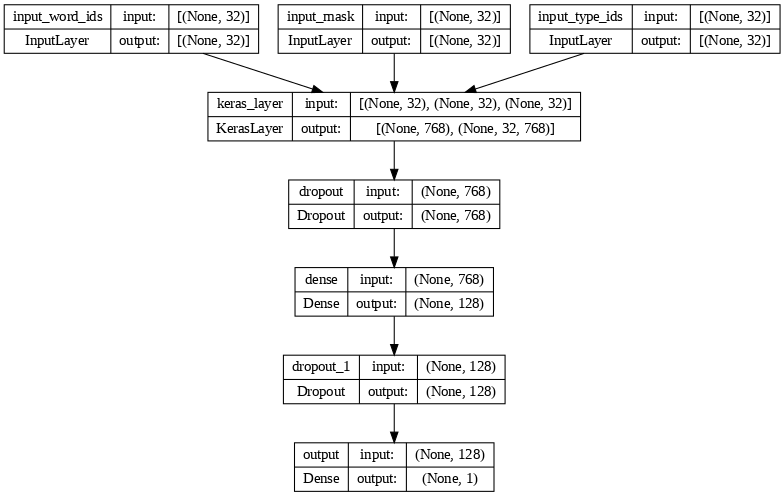

In [ ]:
tf.keras.utils.plot_model(model=model,show_shapes=True,dpi=76)

##### Train the model

In [ ]:
epochs=3
history = model.fit(train_data,
                    #validation_data=valid_data,
                    epochs=epochs,
                    verbose=1)

Epoch 1/3
 699/2919 [======>.......................] - ETA: 32:55 - loss: 0.4316 - accuracy: 0.8504

##### Predictions

In [ ]:
pred = model.predict(test_data)
pred

20219/20219 [==============================] - 429s 21ms/step


array([[0.01738643],
       [0.03219718],
       [0.02066971],
       ...,
       [0.13244724],
       [0.18172093],
       [0.00724495]], dtype=float32)

In [ ]:
probas = [pred[0] for pred in pred]

In [ ]:
classes = ["N" if prob < 0.5 else "Y" for prob in probas]

In [ ]:
submission = pd.DataFrame({"ID":pd.read_csv("testing_data.csv")["id"],"Label":classes})
submission

,ID,Label
0,0,N
1,1,N
2,2,N
3,3,N
4,4,N
...,...,...
20214,20214,N
20215,20215,N
20216,20216,N
20217,20217,N


In [ ]:
classes

In [ ]:
submission.to_csv('sub3.csv', index=False)

In [ ]:
sub.state = probas

##### Saving the File

In [ ]:
sub.to_csv("submission_p4.csv",index = False)

In [ ]:
test_df

,reviews,Label
30124,i seem to stay at the drake during nice weathe...,0
24280,"a favorite for a late lunch, w time to relax. ...",1
31701,traditional brazillian steakhouse. although my...,0
37963,i love this place. i ve only lived in chicago ...,0
15996,mmmmmm...love it.,0
...,...,...
35798,wow! this place is one of the best places to s...,0
3313,i d like to give this place stars. the food he...,0
32723,"decent sized place with a long bar front, sepa...",0
9327,if you like sausage and you haven t been to ho...,0


In [ ]:
from sklearn.metrics import accuracy_score

auc_score = accuracy_score(test_df.Label, classes)
print("AUC Score:", auc_score)


AUC Score: 0.8295348837209302


In [ ]:
custom_objects = {'KerasLayer': bert_layer}

from tensorflow.keras.models import load_model

model = load_model('bert4.h5', custom_objects=custom_objects)
